# Machine Translation and Data Sets


In [1]:
import sys
sys.path.insert(0, '..')

import collections
import d2l
import zipfile

from mxnet import nd
from mxnet.gluon import utils as gutils, data as gdata

## Read and Pre-process Data

In [2]:
fname = gutils.download('http://www.manythings.org/anki/fra-eng.zip')
with zipfile.ZipFile(fname, 'r') as f:
    raw_text = f.read('fra.txt').decode("utf-8")
print(raw_text[0:95])

Go.	Va !
Hi.	Salut !
Run!	Cours !
Run!	Courez !
Who?	Qui ?
Wow!	Ça alors !
Fire!	Au feu !
Help!


Preprocessing 

In [3]:
def preprocess_raw(text):
    text = text.replace('\u202f', ' ').replace('\xa0', ' ')
    out = ''
    for i, char in enumerate(text.lower()):
        if char in (',', '!', '.') and i > 0 and text[i-1] != ' ':
            out += ' '
        out += char
    return out

text = preprocess_raw(raw_text)
print(text[0:95])

go .	va !
hi .	salut !
run !	cours !
run !	courez !
who?	qui ?
wow !	ça alors !
fire !	au feu !


## Tokenization


In [4]:
num_examples = 50000
source, target = [], []
for i, line in enumerate(text.split('\n')):
    if i > num_examples:
        break
    parts = line.split('\t')
    if len(parts) == 2:
        source.append(parts[0].split(' '))
        target.append(parts[1].split(' '))

source[0:3], target[0:3]

([['go', '.'], ['hi', '.'], ['run', '!']],
 [['va', '!'], ['salut', '!'], ['cours', '!']])

Histogram of the number of tokens per sentence.

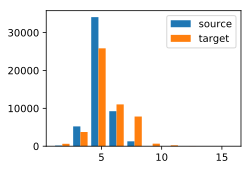

In [5]:
d2l.set_figsize()
d2l.plt.hist([[len(l) for l in source], [len(l) for l in target]],
             label=['source', 'target'])
d2l.plt.legend(loc='upper right');

## Vocabulary

In [6]:
def build_vocab(tokens):
    tokens = [token for line in tokens for token in line]
    return d2l.Vocab(tokens, min_freq=3, use_special_tokens=True)

src_vocab = build_vocab(source)
len(src_vocab)

3790

## Load Dataset

In [7]:
def pad(line, max_len, padding_token):
    if len(line) > max_len:
        return line[:max_len]
    return line + [padding_token] * (max_len - len(line))

pad(src_vocab[source[0]], 10, src_vocab.pad)

[37, 4, 0, 0, 0, 0, 0, 0, 0, 0]

Convert a list of sentences into an `(num_example, max_len)` index array. 

In [8]:
def build_array(lines, vocab, max_len, is_source):
    lines = [vocab[line] for line in lines]
    if not is_source:
        lines = [[vocab.bos] + line + [vocab.eos] for line in lines]
    array = nd.array([pad(line, max_len, vocab.pad) for line in lines])
    valid_len = (array != vocab.pad).sum(axis=1)
    return array, valid_len

Construct data iterators to read data batches.

In [9]:
def load_data_nmt(batch_size, max_len):  # This function is saved in d2l.
    src_vocab, tgt_vocab = build_vocab(source), build_vocab(target)
    src_array, src_valid_len = build_array(source, src_vocab, max_len, True)
    tgt_array, tgt_valid_len = build_array(target, tgt_vocab, max_len, False)
    train_data = gdata.ArrayDataset(
        src_array, src_valid_len, tgt_array, tgt_valid_len)
    train_iter = gdata.DataLoader(train_data, batch_size, shuffle=True)
    return src_vocab, tgt_vocab, train_iter

Let's read the first batch.

In [10]:
src_vocab, tgt_vocab, train_iter = load_data_nmt(batch_size=2, max_len=8)
for X, X_valid_len, Y, Y_valid_len, in train_iter:
    print('X =', X.astype('int32'), '\nValid lengths for X =', X_valid_len,
          '\nY =', Y.astype('int32'), '\nValid lengths for Y =', Y_valid_len)
    break

X = 
[[  21   58 3561    4    0    0    0    0]
 [  43   32  626  378    4    0    0    0]]
<NDArray 2x8 @cpu(0)> 
Valid lengths for X = 
[4. 5.]
<NDArray 2 @cpu(0)> 
Y = 
[[  1   9  35 167 322  13   2   0]
 [  1  16  41  73  26  84   8 425]]
<NDArray 2x8 @cpu(0)> 
Valid lengths for Y = 
[7. 8.]
<NDArray 2 @cpu(0)>
